Based on: https://strike.scec.org/cvws/seas/download/SEAS_BP1_QD.pdf
And: https://strike.scec.org/cvws/seas/download/apr23_2018/Erickson-Jiang_Benchmark_results_and_discussions.pdf

Goals:
- email SEAS people to get a time series for one of the backslip models
- make another version that also includes a viscoelastic layer!
- probable issues with the fault tip:
    - debug the weird wavyness I'm seeing in the comparison with Junle Jiang's results from SEAS
    - debug the crazyness that happens when I increase to 16th order panels.

Possible issues:

Fault tips: 
- Identify or specify singularities and then make sure that the QBX and quadrature account for the singularities. This would be helpful for avoiding the need to have the sigmoid transition.
- *Would it be useful to use an interpolation that includes the end points so that I can easily make sure that slip goes to zero at a fault tip?* --> I should test this!

Initial conditions:
- Is the creep initial condition somehow wrong?
- Would a slip deficit formulation be easier to get right?
- What about just using far-field plate rate BCs?
- *The pre-stress formulation from the SEAS document!*

problem: how do I impose a backslip forcing? ultimately, this is physically unrealistic but I need to do it anyway. 
- look at how the scec seas project does this?
- use some tapering function?
- have a basal panel that just has a linear imposed backslip.

In [1]:
from config import setup, import_and_display_fnc

setup()

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix2,
    single_layer_matrix,
    double_layer_matrix,
    adjoint_double_layer_matrix,
    hypersingular_matrix,
    stage1_refine,
    qbx_panel_setup,
    stage2_refine,
    pts_grid,
)

In [3]:
surf_half_L = 100000
fault_bottom = 40000
max_panel_length = 300
shear_modulus = 3.2e10

qx, qw = gauss_rule(6)
t = sp.var("t")

control_points = [
    (0, -fault_bottom / 2, fault_bottom / 2, max_panel_length),
]
fault, free = stage1_refine(
    [
        (t, t * 0, fault_bottom * (t + 1) * -0.5),  # fault
        (t, -t * surf_half_L, 0 * t),  # free surface
    ],
    (qx, qw),
    control_points=control_points,
)

fault_expansions, free_expansions = qbx_panel_setup(
    [fault, free], directions=[0, 1], singularities=np.array([[0, -fault_bottom]])
)

In [4]:
fault.n_panels, fault.n_pts

(256, 1536)

In [5]:
print(fault_expansions.pts)

[[-4.39949334e+00 -5.27581920e+00]
 [-2.47192383e+01 -2.64680167e+01]
 [-5.85937500e+01 -5.94828761e+01]
 ...
 [ 1.39045715e+01 -3.99405171e+04]
 [ 5.86599112e+00 -3.99735320e+04]
 [ 1.04402039e+00 -3.99947242e+04]]


In [6]:
free_disp_to_free_disp = qbx_matrix2(
    double_layer_matrix, free, free.pts, free_expansions, kappa=5
)[:, 0, :]
fault_slip_to_free_disp = qbx_matrix2(
    double_layer_matrix, fault, free.pts, free_expansions, kappa=5
)[:, 0, :]

free_disp_solve_mat = np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
free_disp_solve_mat_inv = np.linalg.inv(free_disp_solve_mat)

In [7]:
fault_slip_to_fault_stress = shear_modulus * qbx_matrix2(
    hypersingular_matrix, fault, fault.pts, fault_expansions, kappa=5
)
free_disp_to_fault_stress = shear_modulus * qbx_matrix2(
    hypersingular_matrix, free, fault.pts, fault_expansions, kappa=5
)

In [8]:
fault_slip_to_fault_traction = np.sum(
    fault_slip_to_fault_stress * fault.normals[:, :, None], axis=1
)
free_disp_to_fault_traction = np.sum(
    free_disp_to_fault_stress * fault.normals[:, :, None], axis=1
)

$$
\int_{H} H^* u + \int_{F} H^* s = t
$$
$$
u + \int_{H} T^* u + \int_{F} T^* s = 0
$$

Copy the derivation on my whiteboard

In [9]:
A = fault_slip_to_fault_traction
B = free_disp_to_fault_traction
C = fault_slip_to_free_disp
Dinv = free_disp_solve_mat_inv
total_fault_slip_to_fault_traction = A - B.dot(Dinv.dot(C))

In [10]:
fault_slip_to_fault_stress2 = shear_modulus * qbx_matrix2(
    hypersingular_matrix, fault, fault.pts, fault_expansions, kappa=6, p=11
)

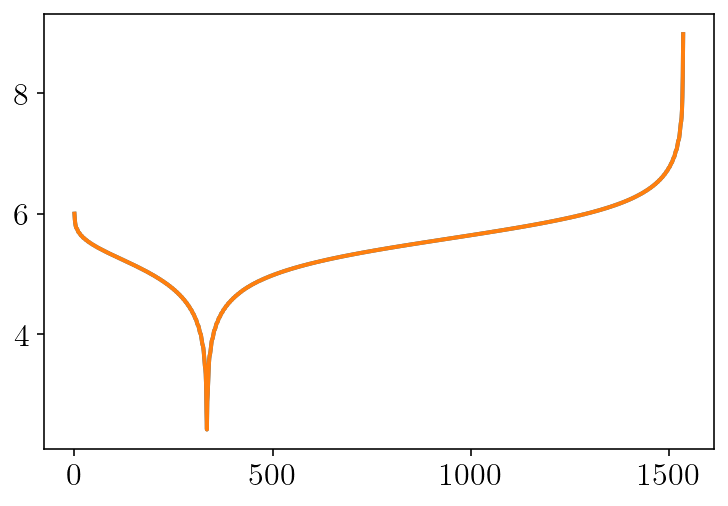

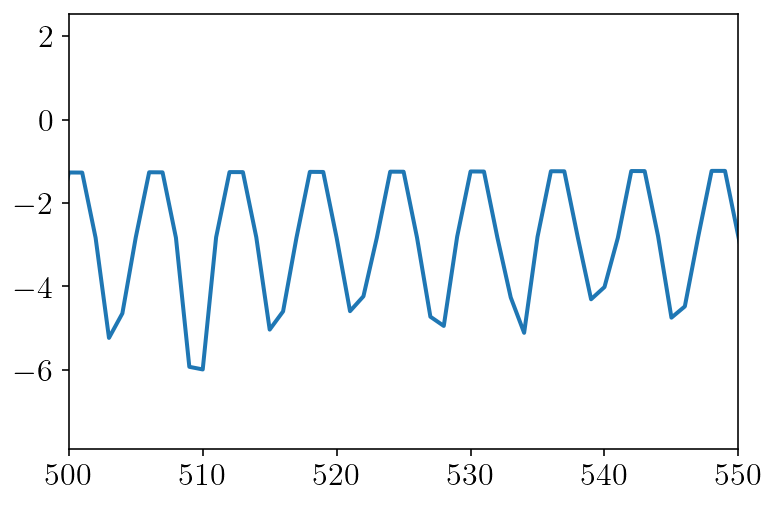

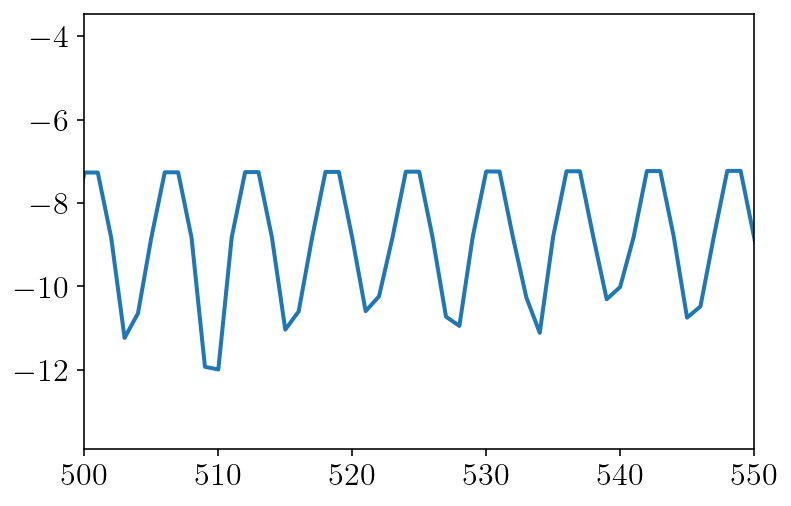

In [11]:
slip = fault.pts[:, 1] / fault_bottom
v1 = fault_slip_to_fault_stress.dot(slip)[:, 0]
v2 = fault_slip_to_fault_stress2.dot(slip)[:, 0]
plt.plot(np.log10(np.abs(v1)))
plt.plot(np.log10(np.abs(v2)))
plt.show()
plt.plot(np.log10(np.abs(v1 - v2)))
plt.xlim([500, 550])
plt.show()
plt.plot(np.log10(np.abs((v1 - v2) / 1e6)))
plt.xlim([500, 550])
plt.show()

In [11]:
# M4 = total_fault_slip_to_fault_traction

# np.max(np.abs((M4 - M2) / M2))

## Rate and state friction

In [12]:
from dataclasses import dataclass

In [13]:
@dataclass
class FrictionParams:
    a: np.ndarray
    b: float
    V0: float
    Dc: float
    f0: float

In [14]:
siay = 31556952
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
eta = shear_modulus / (2 * cs)  # The radiation damping coefficient (kg / (m^2 * s))
Vp = 1e-9  # Rate of plate motion
sigma_n = 50e6  # Normal stress (Pa)

a0 = 0.01
amax = 0.025
fy = fault.pts[:, 1]
H = 15000
h = 3000
a = np.where(
    fy > -H, a0, np.where(fy > -(H + h), a0 + (amax - a0) * (fy + H) / -h, amax)
)

fp = FrictionParams(
    a=a,  # direct velocity strengthening effect
    b=0.015,  # state-based velocity weakening effect
    Dc=0.008,  # state evolution length scale (m)
    f0=0.6,  # baseline coefficient of friction
    V0=1e-6,  # when V = V0, f = f0, V is (m/s)
)

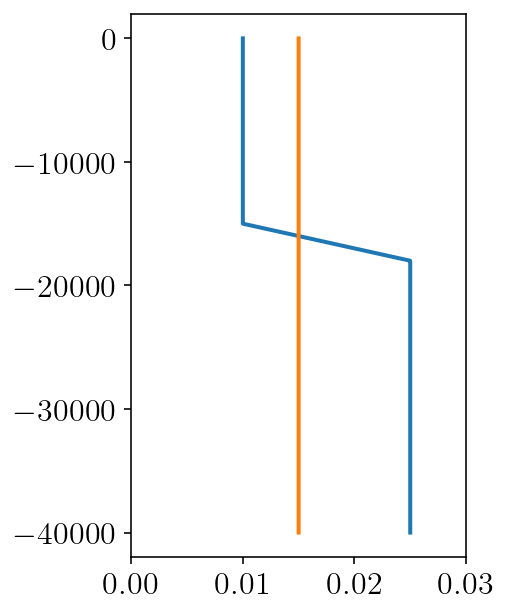

In [15]:
plt.figure(figsize=(3, 5))
plt.plot(fp.a, fy)
plt.plot(np.full(fy.shape[0], fp.b), fy)
plt.xlim([0, 0.03])
plt.show()

In [16]:
mesh_L = np.max(np.abs(np.diff(fault.pts[:, 1])))
Lb = shear_modulus * fp.Dc / (sigma_n * fp.b)
hstar = (np.pi * shear_modulus * fp.Dc) / (sigma_n * (fp.b - fp.a))
mesh_L, Lb, np.min(hstar[hstar > 0])

(37.28424782550428, 341.3333333333333, 3216.990877275949)

In [17]:
def aging_law(fp, V, state):
    return (fp.b * fp.V0 / fp.Dc) * (np.exp((fp.f0 - state) / fp.b) - (V / fp.V0))

In [18]:
def F(fp, V, state):
    return sigma_n * fp.a * np.arcsinh(V / (2 * fp.V0) * np.exp(state / fp.a))


def dFdV(fp, V, state):
    expsa = np.exp(state / fp.a)
    Q = (V * expsa) / (2 * fp.V0)
    return fp.a * expsa * sigma_n / (2 * fp.V0 * np.sqrt(1 + Q * Q))

In [19]:
def qd_equation(fp, shear_stress, V, state):
    return shear_stress - eta * V - F(fp, V, state)


def qd_equation_dV(fp, V, state):
    return -eta - dFdV(fp, V, state)


def rate_state_solve_old(fp, shear, V_old, state, tol=1e-10, V_min=1e-30):
    def qd(V):
        return qd_equation(fp, shear, V, state)

    def qd_dV(V):
        return qd_equation_dV(fp, V, state)

    V = V_old
    max_iter = 150
    for i in range(max_iter):
        f = qd_equation(fp, shear, V, state)
        dfdv = qd_equation_dV(fp, V, state)
        Vn = np.maximum(V - (f / dfdv), V_min)
        if np.max(np.abs(V - Vn) / np.minimum(Vn, V)) < tol:
            break
        V = Vn
        if i == max_iter - 1:
            raise Exception("Failed to converge.")
    return Vn

In [20]:
%load_ext cython

In [21]:
%%cython --verbose
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport asinh, exp, sqrt, fabs, fmax, fmin

def rate_state_solve(
    fp, double sigma_n, double eta, 
    double[::1] shear, double[::1] V_old, double[::1] state, 
    int max_iter=100, double tol=1e-10, double V_min=1e-30
):
    cdef double[::1] fp_a = fp.a
    cdef double fp_b = fp.b
    cdef double fp_V0 = fp.V0
    
    cdef int n = shear.shape[0]
    cdef out_V = np.empty(n, dtype=np.float64)
    cdef double[::1] V = out_V
    
    cdef int i, j
    cdef double F, dFdV, qd_eqtn, Q, qd_eqtn_dV, V_tmp, sigma_F, expsa
    cdef bint failed = False
    
    # We don't parallelize here because the small problems here have more 
    # parallelization overhead than speedup.
    for j in range(n):
        V[j] = V_old[j]
        expsa = exp(state[j] / fp_a[j]) / (2 * fp_V0)
        sigma_F = sigma_n * fp_a[j]
        for i in range(max_iter):
            Q = V[j] * expsa
            F = sigma_F * asinh(Q)
            qd_eqtn = shear[j] - eta * V[j] - F
    
            dFdV = sigma_F * expsa / sqrt(1 + Q * Q)
            qd_eqtn_dV = -eta - dFdV
            
            V_tmp = V[j]
            V[j] = fmax(V[j] - qd_eqtn / qd_eqtn_dV, V_min)
            if fabs(V[j] - V_tmp) / fmin(V[j], V_tmp) < tol:
                break
            if i == max_iter - 1:
                print(V[j], V_tmp)
                failed = True
                
    if failed == 1:
        raise Exception(f"Rate-state Newton failed to converge in {max_iter} iterations.")
    return out_V

In [22]:
shear = np.full(fault.n_pts, 30e6)
V = np.full(fault.n_pts, Vp)
state = np.full(fault.n_pts, 0.7)


def benchmark():
    for i in range(300):
        rate_state_solve(fp, sigma_n, eta, shear, V, state)
        rate_state_solve_old(fp, shear, V, state)

In [23]:
%load_ext line_profiler

%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 1.53829 s
File: <ipython-input-22-f1be73b8d282>
Function: benchmark at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def benchmark():
     7       301        489.0      1.6      0.0      for i in range(300):
     8       300     258789.0    862.6     16.8          rate_state_solve(fp, sigma_n, eta, shear, V, state)
     9       300    1279011.0   4263.4     83.1          rate_state_solve_old(fp, shear, V, state)

In [24]:
V1 = rate_state_solve(fp, sigma_n, eta, shear, V, state)
V2 = rate_state_solve_old(fp, shear, V, state)

np.any(V1 - V2 > 1e-20)

False

## Quasidynamic earthquake cycle derivatives

In [43]:
from scipy.optimize import fsolve
import copy

fp_amax = copy.deepcopy(fp)
fp_amax.a = amax

init_state_scalar = fsolve(lambda S: aging_law(fp, Vp, S), 0.7)[0]
init_state = np.full(fault.n_pts, init_state_scalar)
tau_amax = F(fp_amax, Vp, init_state_scalar) + eta * Vp
init_traction = np.full(fault.n_pts, tau_amax)

In [44]:
init_slip_deficit = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip_deficit, init_state))

In [59]:
def calc_system_state(t, y, verbose=False):
    if verbose:
        print(t)
        print(t)
        print(t)
        print(t)
        print(t)

    slip_deficit = y[: init_slip.shape[0]]
    state = y[init_slip.shape[0] :]

    if np.any((state < 0) | (state > 1.2)):
        return False

    tau_qs = init_traction - total_fault_slip_to_fault_traction.dot(slip_deficit)

    try:
        V = rate_state_solve(fp, sigma_n, eta, tau_qs, calc_system_state.V_old, state)
    except RuntimeError:
        return False
    if not np.all(np.isfinite(V)):
        return False
    calc_system_state.V_old = V

    dstatedt = aging_law(fp, V, state)

    slip_deficit_rate = Vp - V
    out = slip_deficit, state, tau_qs, slip_deficit_rate, dstatedt
    if verbose:
        plot_system_state(out)

    return out


calc_system_state.V_old = np.full(fault.n_pts, Vp)


def plot_system_state(SS):
    slip_deficit, state, tau_qs, slip_deficit_rate, dstatedt = SS

    plt.figure(figsize=(15, 9))
    plt.subplot(2, 3, 1)
    plt.title("slip")
    plt.plot(fault.pts[:, 1], slip_deficit)

    plt.subplot(2, 3, 2)
    plt.title("state")
    plt.plot(fault.pts[:, 1], state)

    plt.subplot(2, 3, 3)
    plt.title("tau qs")
    plt.plot(fault.pts[:, 1], tau_qs)

    plt.subplot(2, 3, 4)
    plt.title("slip rate")
    plt.plot(fault.pts[:, 1], slip_deficit_rate)

    plt.subplot(2, 3, 6)
    plt.title("dstatedt")
    plt.plot(fault.pts[:, 1], dstatedt)
    plt.tight_layout()

    plt.show()


def calc_derivatives(t, y):
    # print('trying', t / siay)
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state = calc_system_state(t, y)  # , verbose=True)
    if not state:
        return np.inf * y
    calc_derivatives.state = state
    derivatives = np.concatenate((state[-2], state[-1]))
    return derivatives

## Integrating through time

In [76]:
from scipy.integrate import RK23, RK45

calc_system_state.V_old = np.full(fault.n_pts, Vp)

atol = Vp * 1e-10
rtol = 1e-7
rk = RK45(calc_derivatives, 0, init_conditions, 1e50, atol=atol, rtol=rtol)
rk.h_abs = 60 * 60 * 24

# n_steps = 100000
max_T = 3000 * siay

t_history = [0]
y_history = [init_conditions.copy()]

n_steps = 12000
for i in range(n_steps):
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
        break

    if i % 1000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs")
        # plot_system_state(calc_derivatives.state)

    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    if rk.t > max_T:
        break

step=0, time=1.4233331578119981e-05 yrs
step=1000, time=33.76465795627742 yrs
step=2000, time=76.68947695579021 yrs
step=3000, time=119.62528380263207 yrs
step=4000, time=162.4946605986458 yrs
step=5000, time=196.1331382368431 yrs
step=6000, time=196.1331384888398 yrs
step=7000, time=196.13313869327763 yrs
step=8000, time=196.13313888603201 yrs
step=9000, time=196.13313900148643 yrs
step=10000, time=196.13426599626374 yrs
step=11000, time=211.02270844333333 yrs


In [77]:
196.13312936477178

196.13312936477178

In [78]:
rk.t / siay

253.12346126265157

In [79]:
y_history = np.array(y_history)
t_history = np.array(t_history)

## Plotting the results

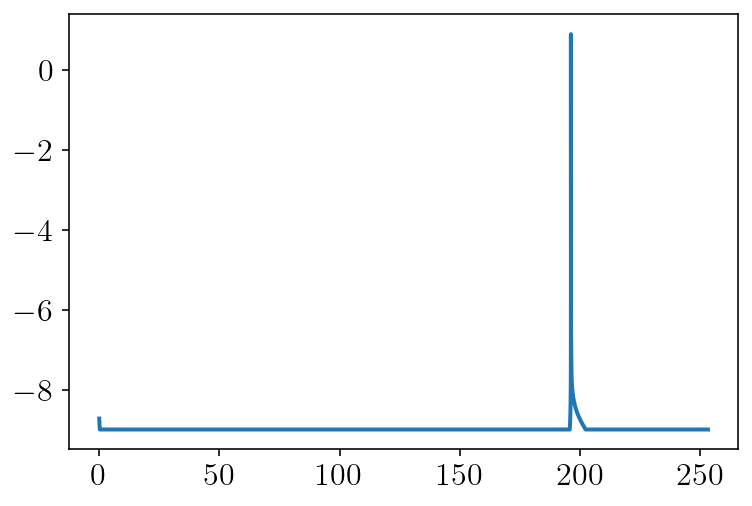

In [80]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.show()

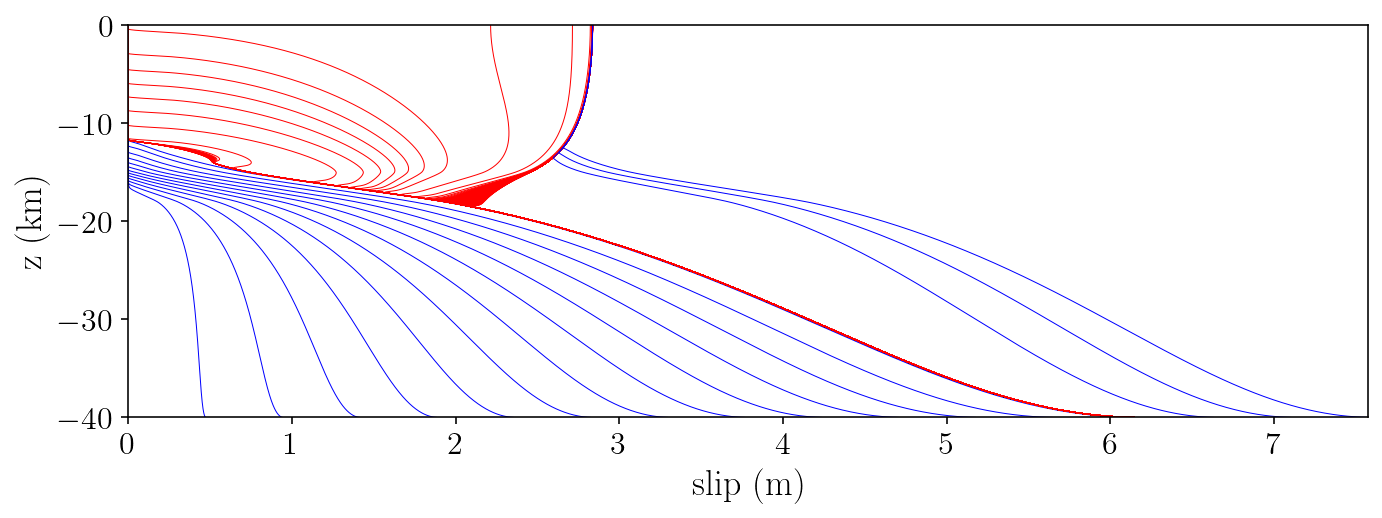

In [81]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip.shape[0]]
    should_plot = False
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):  # np.max(np.abs(slip - last_plt_slip)) > 0.25:
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"
    if should_plot:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fy / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

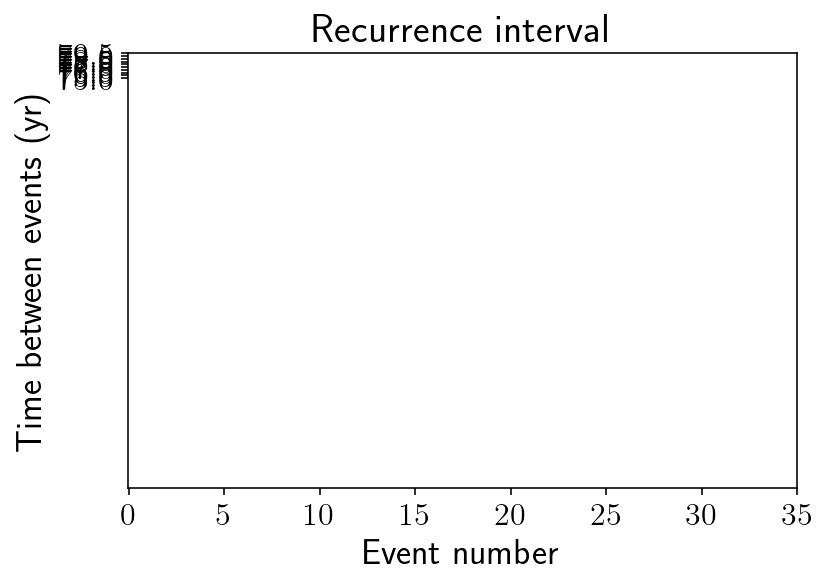

In [82]:
plt.title("Recurrence interval")
plt.plot(np.diff(event_times) / siay, "k-*")
plt.xticks(np.arange(0, 36, 5))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel("Event number")
plt.ylabel("Time between events (yr)")
plt.show()

In [83]:
t_idx = 0  # np.argmax((t_history > event_times[0] - 10))
fault_idx = np.argmax((-7480 > fy) & (fy > -7500))
n_steps = 12000
t_chunk = t_history[t_idx : (t_idx + n_steps)]
y_chunk = y_history[t_idx : (t_idx + n_steps)]
shear_chunk = []
slip_rate_chunk = []
slip_deficit_chunk = []
for i in range(n_steps):
    system_state = calc_system_state(t_history[t_idx + i], y_history[t_idx + i])
    slip_deficit, state, tau_qs, slip_deficit_rate, dstatedt = system_state
    V = Vp - slip_deficit_rate
    slip_deficit_chunk.append(slip_deficit)
    shear_chunk.append((tau_qs - eta * V))
    slip_rate_chunk.append(V)

shear_chunk = np.array(shear_chunk)
slip_rate_chunk = np.array(slip_rate_chunk)
slip_deficit_chunk = np.array(slip_deficit_chunk)

In [84]:
t_start = t_chunk[np.argmax(slip_rate_chunk[:,fault_idx] > 0.1)]

In [85]:
jiang_data = np.loadtxt("jiang.txt")
jiang_vel = np.diff(jiang_data[:, 1]) / np.diff(jiang_data[:, 0])
jiang_t_start = np.argmax(jiang_vel > 0.1)

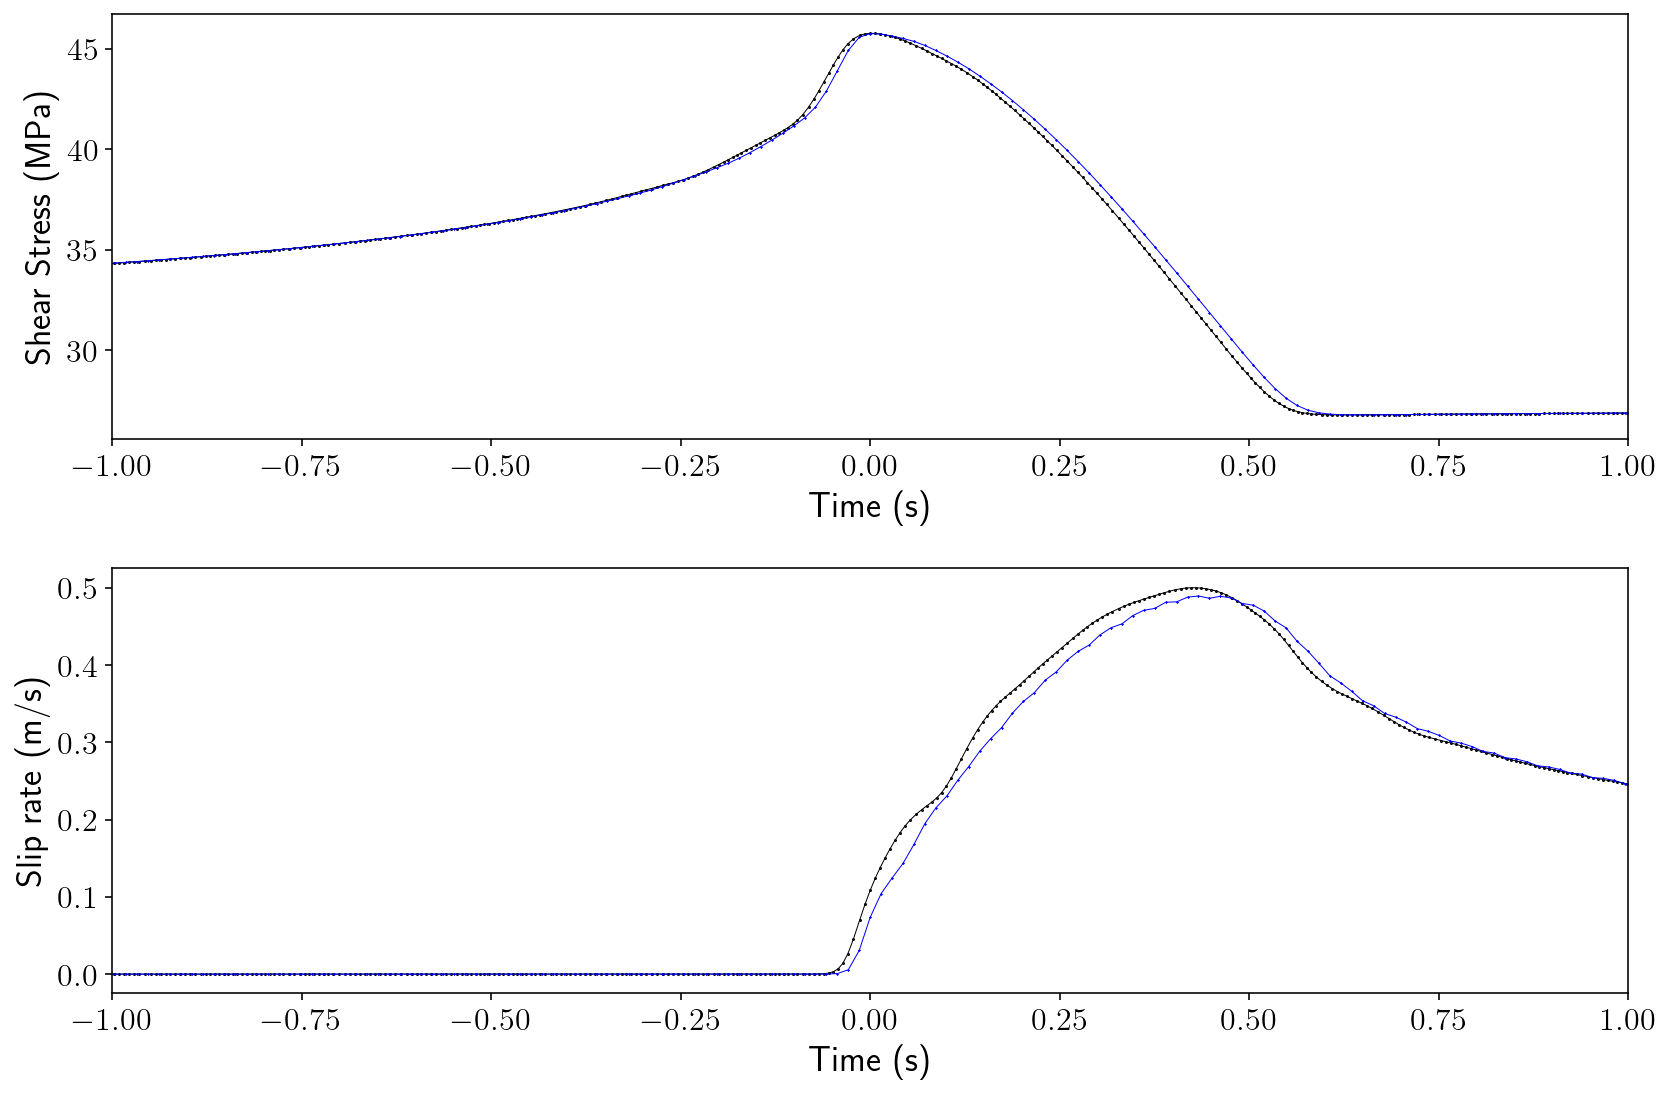

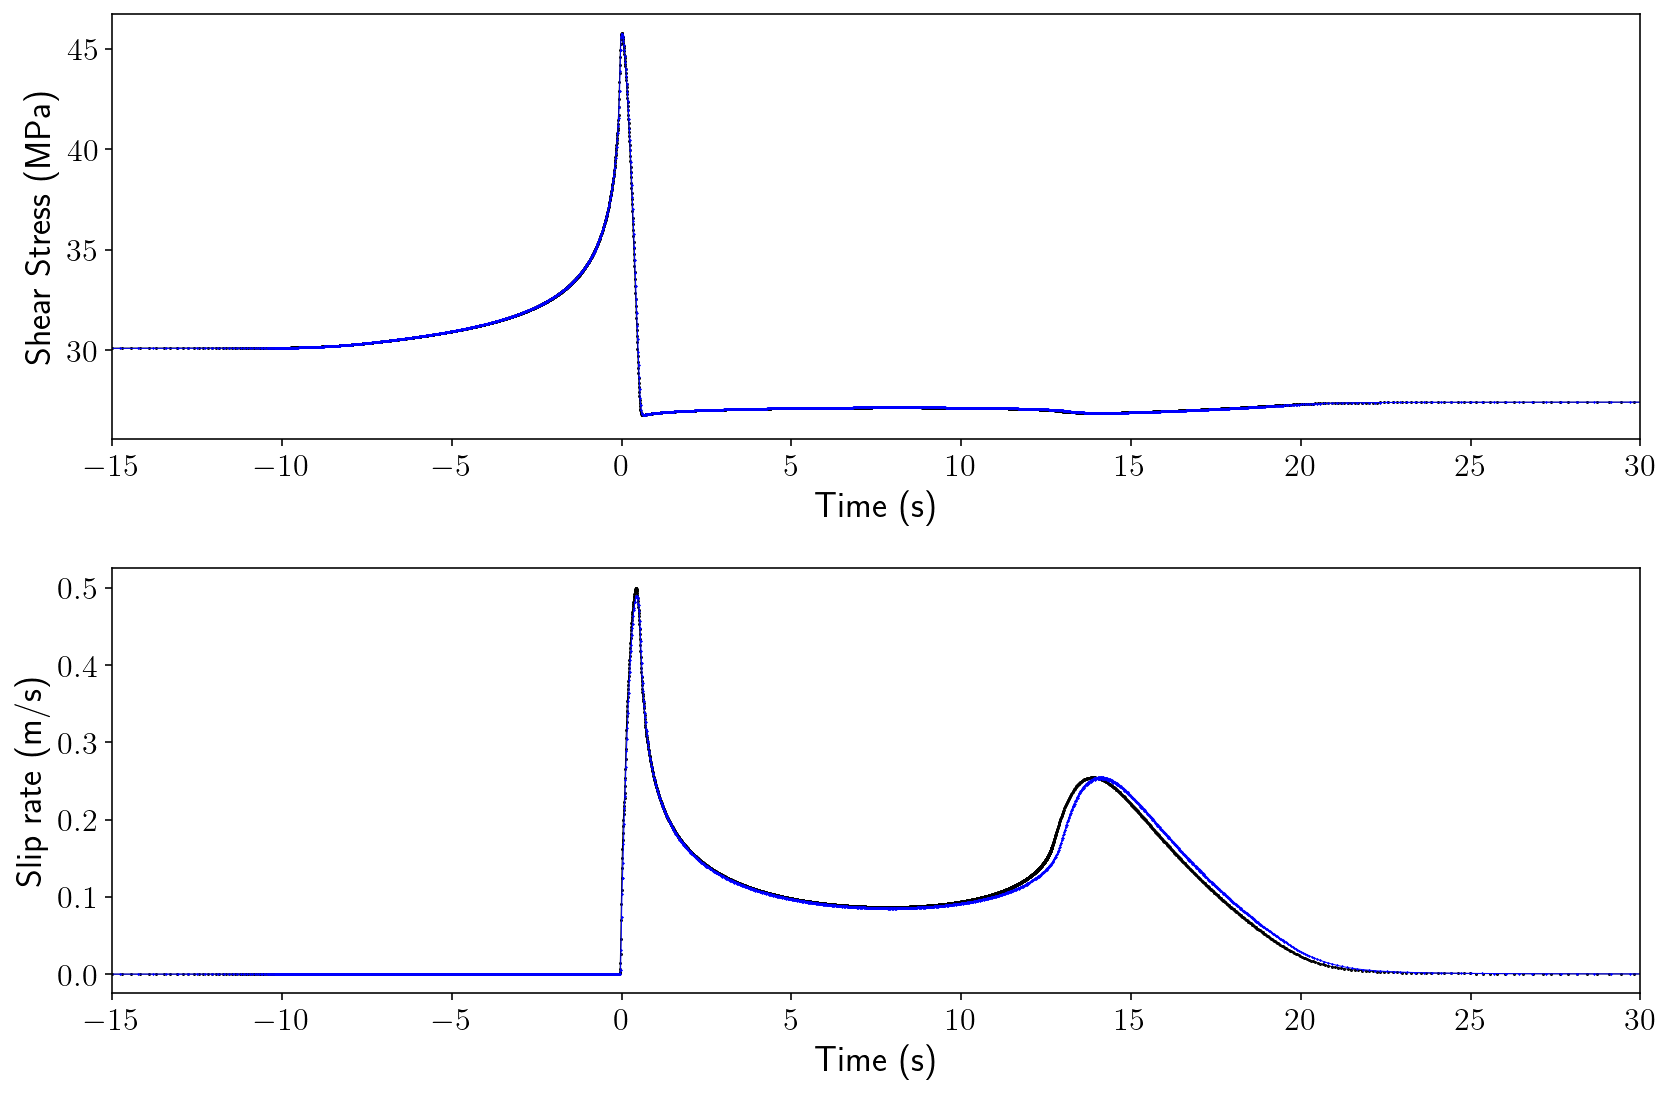

In [86]:
for lims in [(-1, 1), (-15, 30)]:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t_chunk - t_start, shear_chunk[:,fault_idx] / 1e6, "k-o", markersize=0.5, linewidth=0.5)
    plt.plot(
        jiang_data[:, 0] - jiang_data[jiang_t_start, 0],
        jiang_data[:, 3],
        "b-*",
        markersize=0.5,
        linewidth=0.5,
    )
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Shear Stress (MPa)")
    # plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(t_chunk - t_start, slip_rate_chunk[:,fault_idx], "k-o", markersize=0.5, linewidth=0.5)
    plt.plot(
        jiang_data[1:, 0] - jiang_data[jiang_t_start, 0],
        jiang_vel[:],
        "b-*",
        markersize=0.5,
        linewidth=0.5,
    )
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Slip rate (m/s)")
    plt.tight_layout()
    plt.show()

In [60]:
shear_chunk.shape

(12000, 1536)

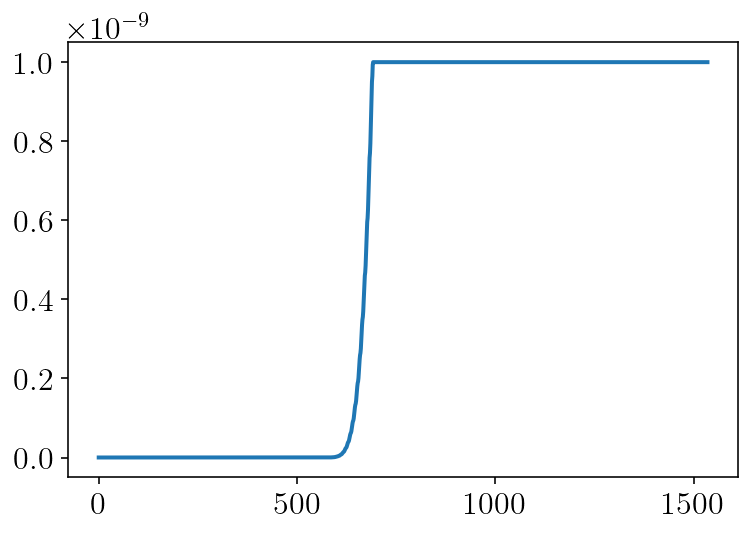

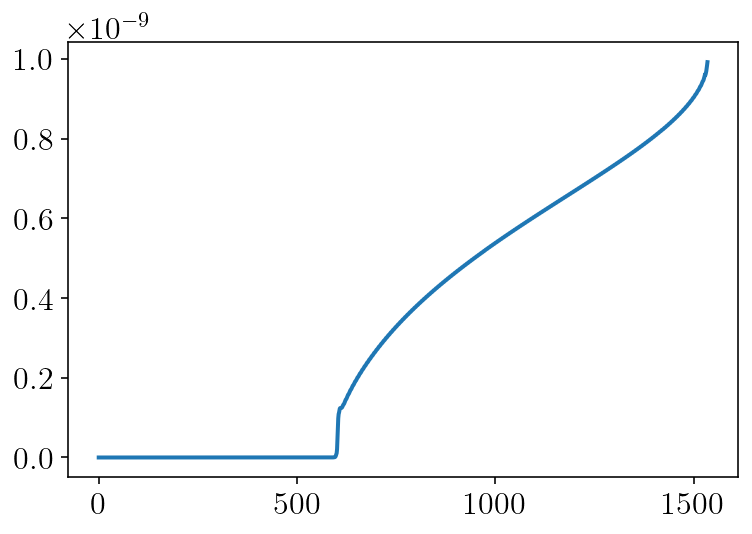

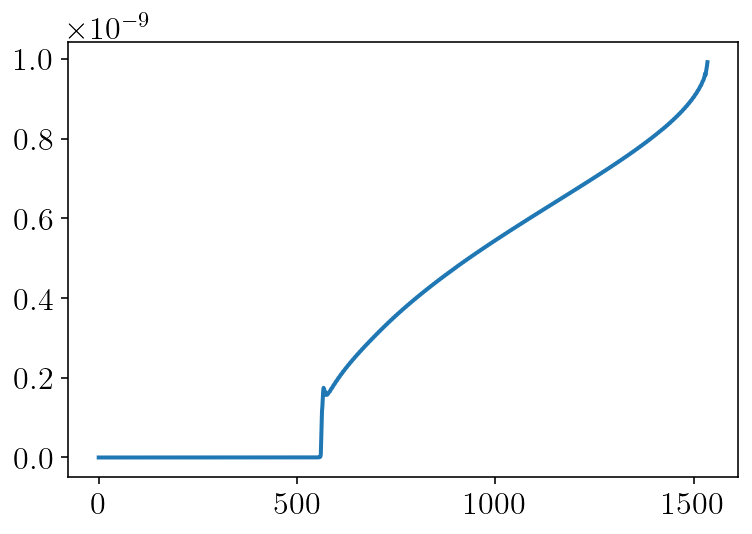

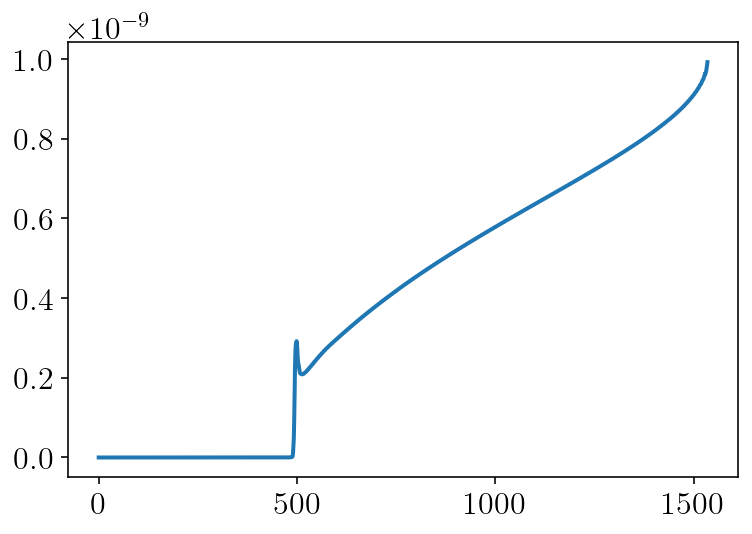

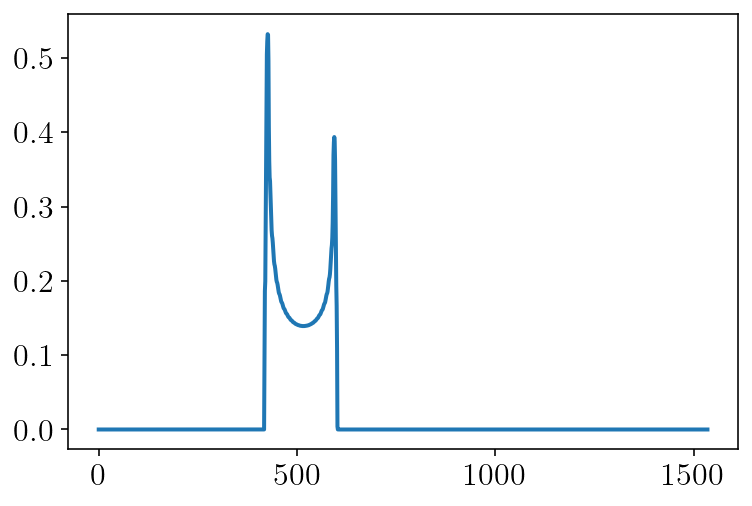

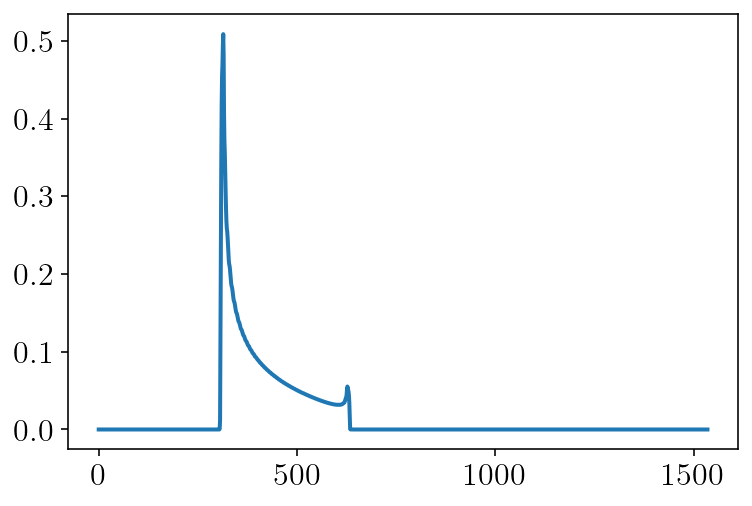

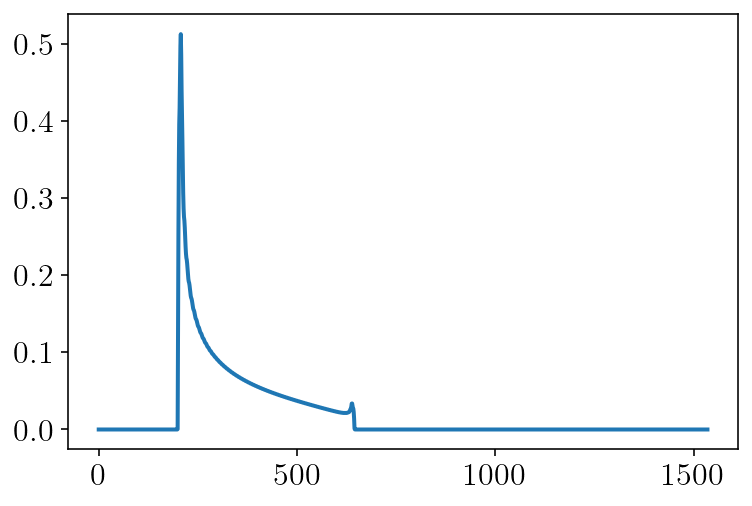

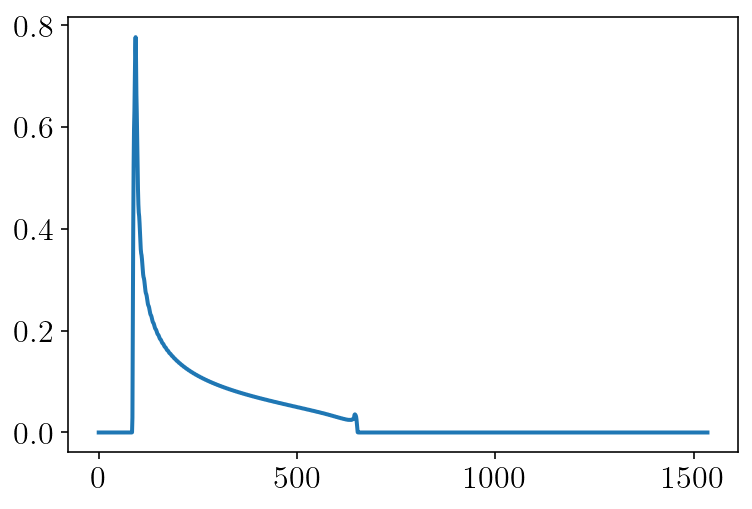

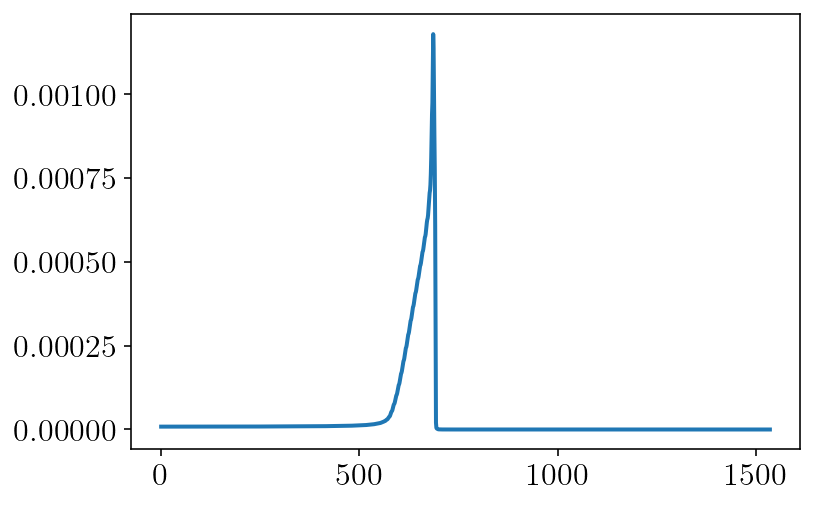

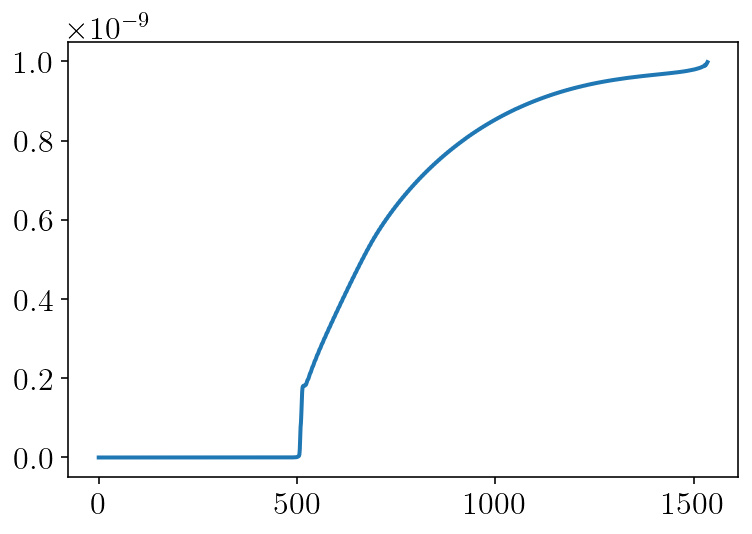

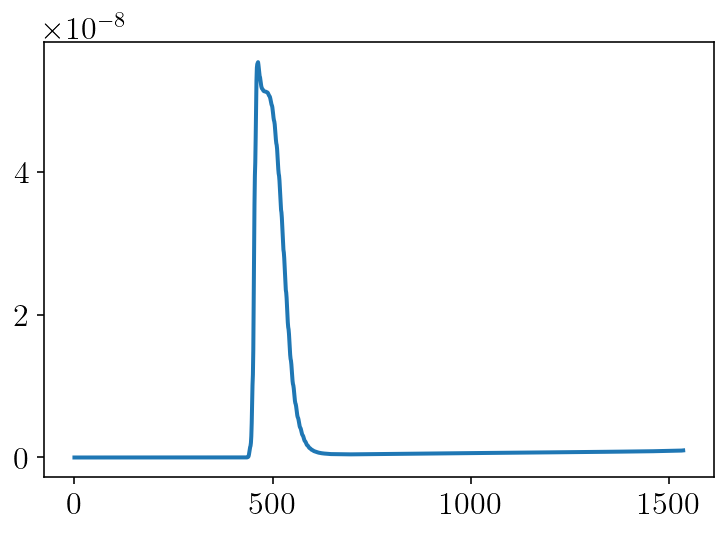

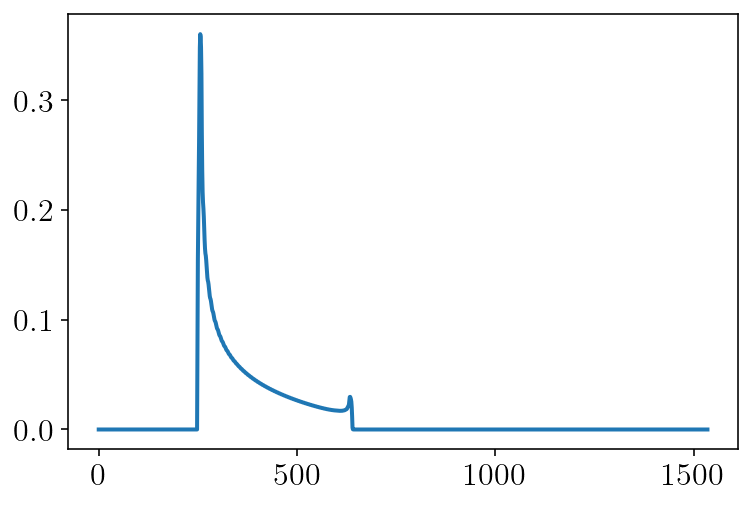

In [65]:
for i in range(0, 12000, 1000):
    plt.plot(
        slip_rate_chunk[
            i,
        ]
    )
    plt.show()

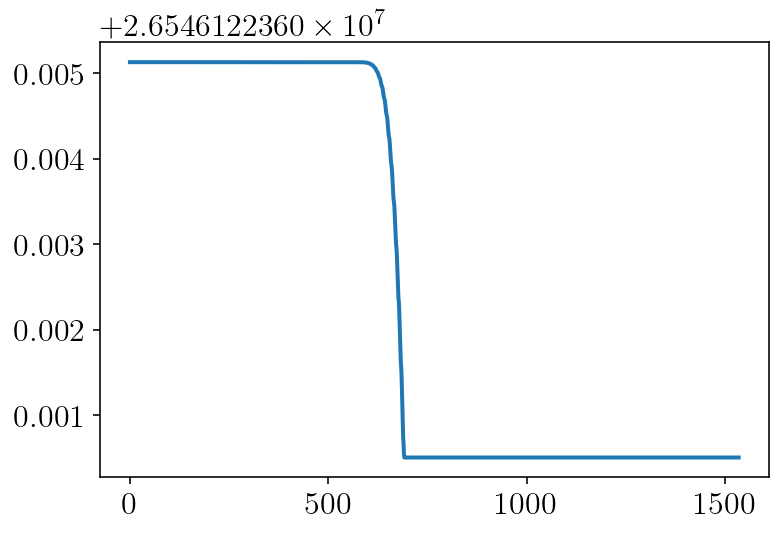

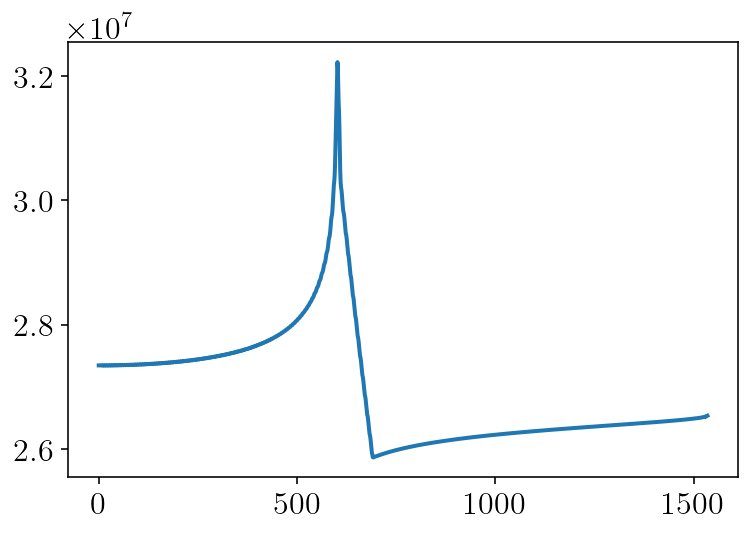

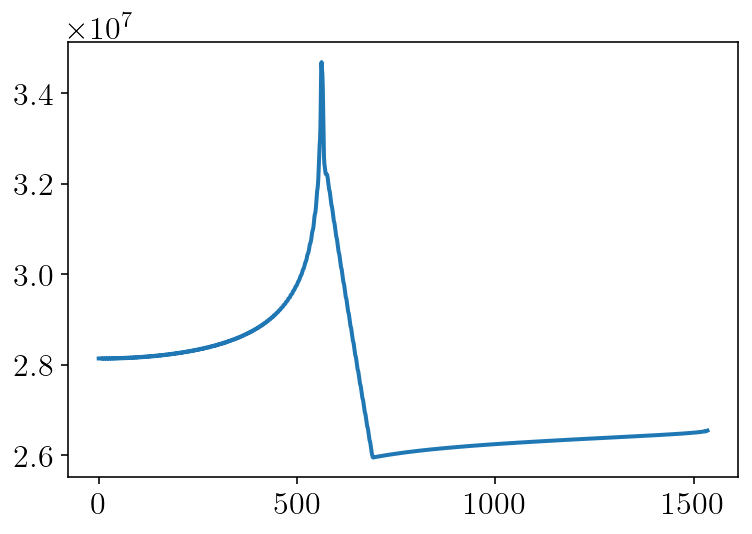

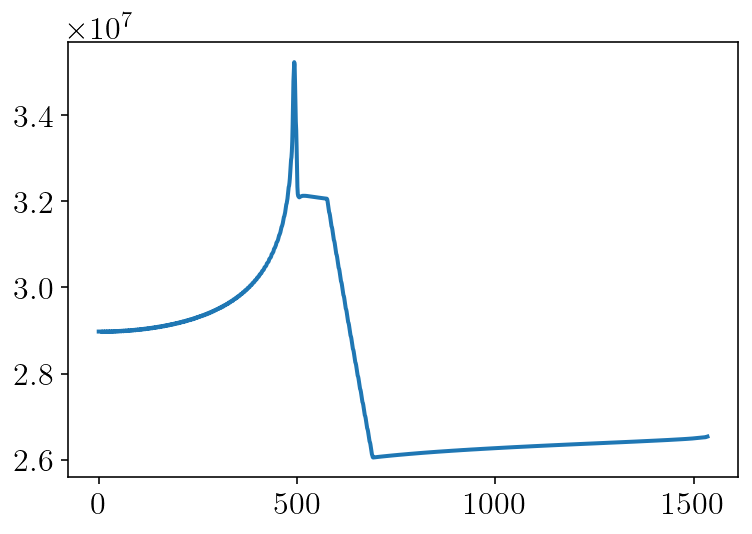

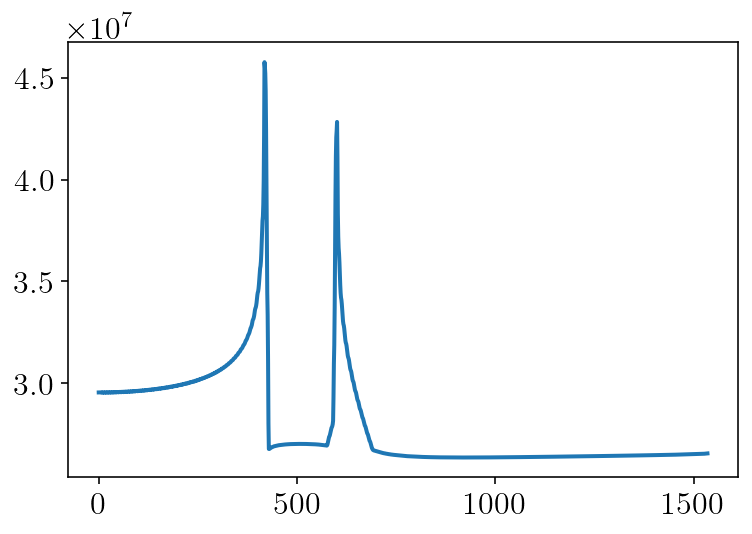

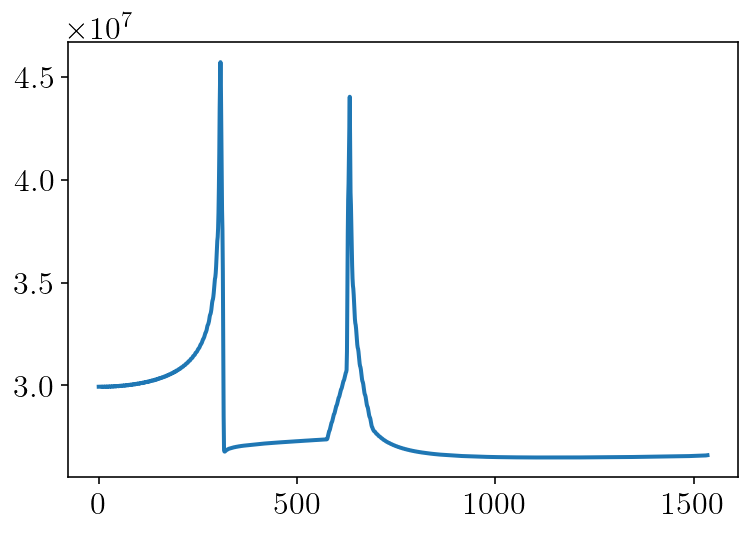

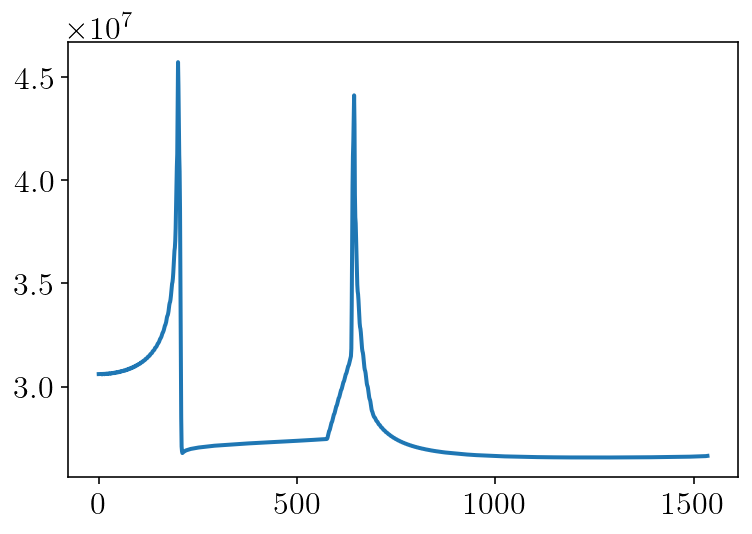

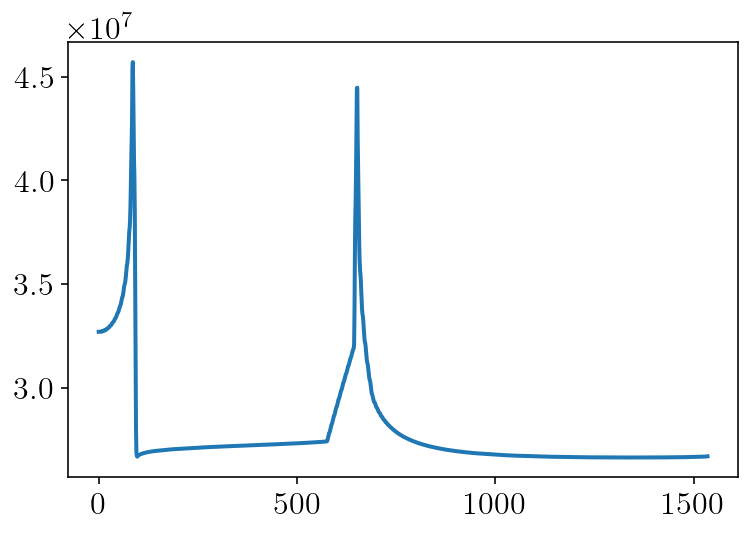

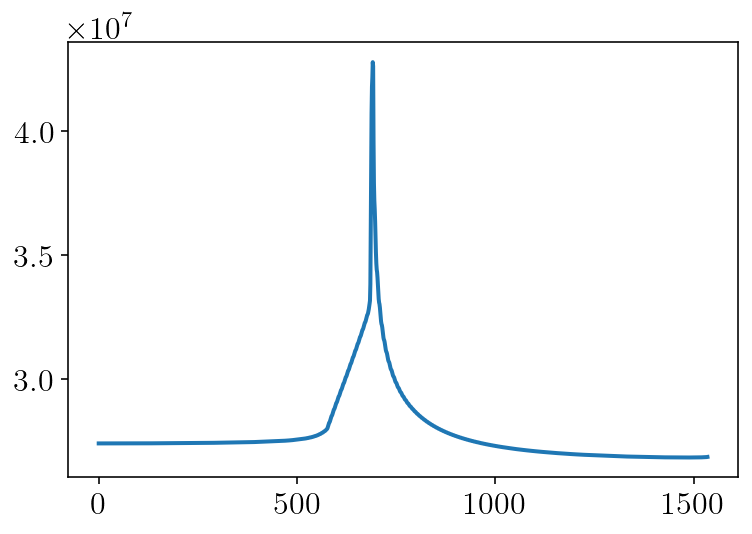

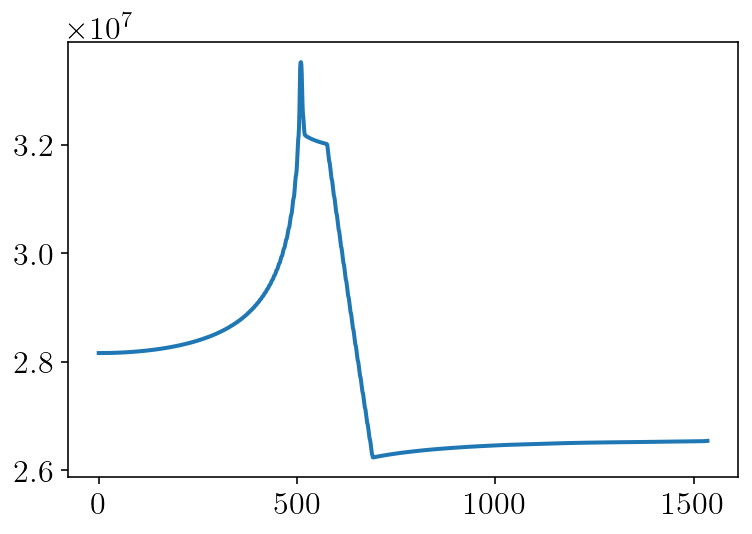

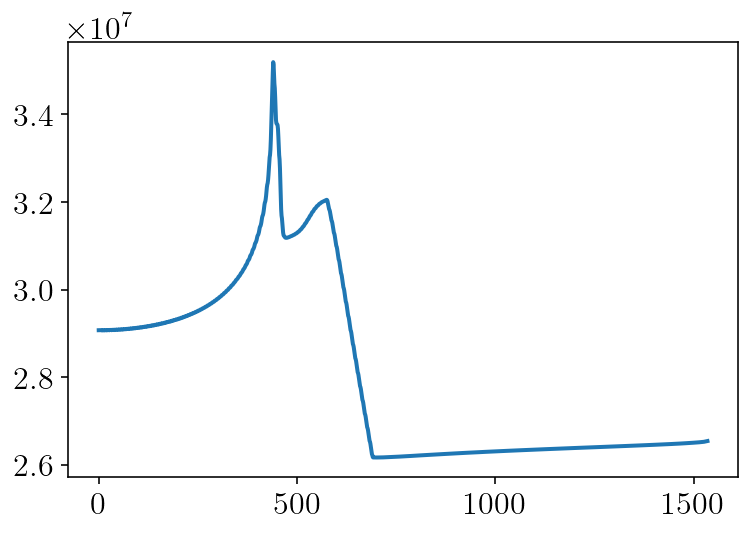

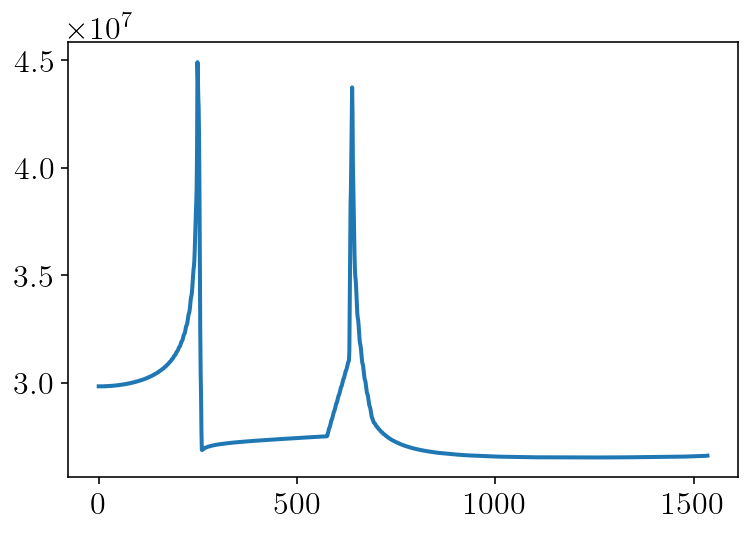

In [64]:
for i in range(0, 12000, 1000):
    plt.plot(
        shear_chunk[
            i,
        ]
    )
    plt.show()

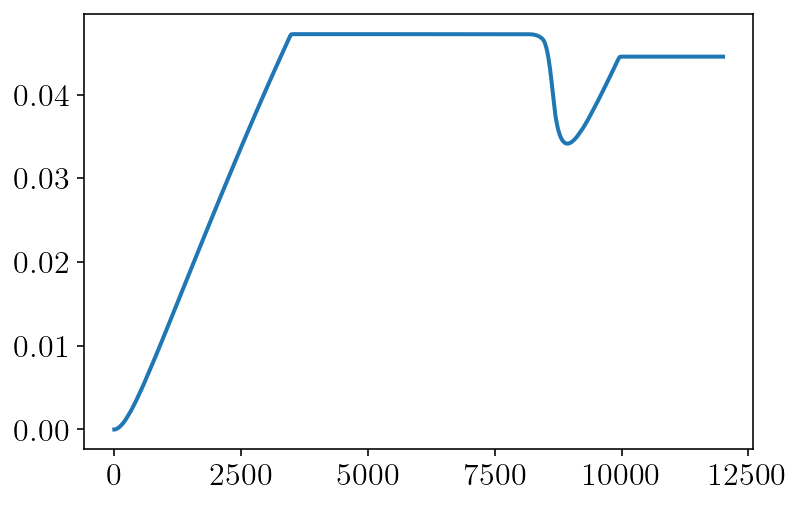

In [55]:
plt.plot(Vp * t_history - y_history[:, fault.n_pts - 1])
plt.show()